Shape of output from NN: torch.Size([1, 400])


/var/folders/yc/l4r8vtpd737bn2v731bzmjsm0000gn/T/ipykernel_46407/1794204627.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


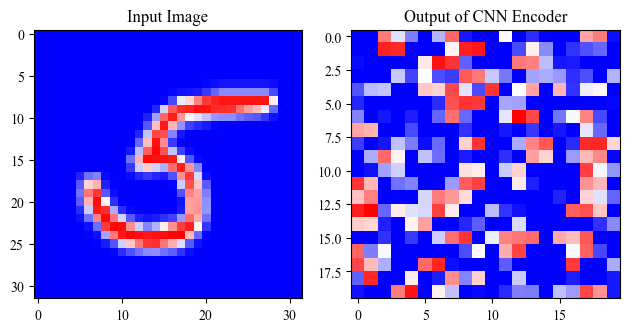

In [1]:
import ctypes
from dataset import getMNIST
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from lenet5.nn import ConvNeuralNet
from utils import getTorchDevice
import torch
import random
import math
# Plot Font Config 

import matplotlib.font_manager

font_dirs = ['./IBM_Plex_Sans/']
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    matplotlib.font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Times New Roman'

train_dataset, test_dataset, train_loader, test_loader = getMNIST(batch_size=64)
hdcLib = ctypes.CDLL("../HDC/hdcLib.dylib")
device = torch.device("cpu")
model = ConvNeuralNet(num_classes=10).to(device)
model.load("lenet5.pth")
index = random.randint(0, len(train_dataset))
sample_image = train_dataset[index][0].float().to(device)
sample_image = sample_image.unsqueeze(0) 
out = model.forwardWithoutLastLayer(x=sample_image)
print(f"Shape of output from NN: {out.shape}")
# plt.imshow(out.detach().cpu().numpy().reshape(20, 20))

fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(sample_image.detach().cpu().numpy().reshape(32, 32), cmap="bwr")
ax1.set_title("Input Image")

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(out.detach().cpu().numpy().reshape(20,20), cmap="bwr")
ax2.set_title("Output of CNN Encoder")

fig.show()
def getMidOutputOfNN(model, image):
    with torch.no_grad():
        image = image.float().to(device)
        image = image.unsqueeze(0) 
        image = image.unsqueeze(0) 
        return model.forwardWithoutLastLayer(x=image)
y = model.forwardWithoutLastLayer(x=sample_image).detach().numpy()
y = y.astype(np.uint32)

hdcLib.createHV.argtypes = [ctypes.c_void_p, ctypes.c_int]
hdcLib.createHV.restype = ctypes.c_void_p

hdcLib.xorHV.argtypes = [ctypes.c_void_p, ctypes.c_void_p,  ctypes.c_int]
hdcLib.printHV.argtypes = [ctypes.c_void_p, ctypes.c_int]
hdcLib.printHV.restype = ctypes.c_void_p


hdcLib.createProfileVector.argtypes = [ctypes.c_void_p, ctypes.c_int, ctypes.c_int]
hdcLib.createProfileVector.restype = ctypes.c_void_p


hdcLib.infer.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int]
hdcLib.infer.restype = ctypes.c_int

hdcLib.printProfileVectors.argtypes = [ctypes.c_void_p, ctypes.c_int]
hdcLib.printProfileVectors.restype = ctypes.c_void_p



fig.tight_layout()
fig.savefig("sample-cnn-inout.pdf")

In [2]:
a = np.array([15], dtype=np.uint32)
b = np.array([11], dtype=np.uint32)
c = np.array([0], dtype=np.uint32)
a = hdcLib.createHV(a.ctypes.data, a.shape[0])
hdcLib.printHV(a, 1)
b = hdcLib.createHV(b.ctypes.data, b.shape[0])
c = hdcLib.createHV(c.ctypes.data, c.shape[0])
p = hdcLib.createProfileVector(np.array([a, b, c]).ctypes.data, 3, 1)
hdcLib.printHV(p, 1)

00000000000000000000000000001111(0xf) 00000000000000000000000000000000(0x0) 00000000000000000000000000000000(0x0) 00000000000000000000000000000000(0x0) 
Create a profile vector with 3 vectors, each with size 1.
Number of cells: 1
00000000000000000000000000001011(0xb) 00000000000000000000000000000000(0x0) 00000000000000000000000000000000(0x0) 00000000000000000000000000000000(0x0) 


8454332744

In [3]:
# a = np.array([8, 9, 10, 11, 12, 13, 14, 15], dtype=np.uint32)
# b = np.array([0, 1, 2, 3, 4, 5, 6, 7], dtype=np.uint32)
# c = np.array([0, 1, 8, 3, 4, 5, 6, 7], dtype=np.uint32)

# a = hdcLib.createHV(a.ctypes.data, a.shape[0])
# b = hdcLib.createHV(b.ctypes.data, b.shape[0])
# c = hdcLib.createHV(c.ctypes.data, c.shape[0])
# # # # # b = hdcLib.createHV(y.ctypes.data, y.shape[1])
# # # # # c = hdcLib.xorHV(a, b, y.shape[1])

# # # # hdcLib.sumWord.argtypes = [ctypes.c_void_p, ctypes.c_int]
# # # hdcLib.sumWord.restype = ctypes.c_uint64
# # # # hdcLib.printHV(a, y.shape[1])
# # # # hdcLib.sumWord(a, y.shape[1])
# hdcLib.printHV(a, 2)
# hdcLib.printHV(b, 2)
# hdcLib.printHV(c, 2)

# p = hdcLib.createProfileVector(np.array([a, b, c]).ctypes.data, 3, 8)
# hdcLib.printHV(p, 2)

In [4]:
def createHVs(model, train_loader):
    model.enableHDC()
    with torch.no_grad():
        hvs = []
        _labels = []
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            for j in range(len(labels)):
                hv = hdcLib.createHV(outputs[j].detach().numpy().astype(np.uint32).ctypes.data, 400)
                hvs.append(hv)
                _labels.append(labels[j])
            _, predicted = torch.max(outputs.data, 1)
            
        return hvs, _labels
    
hvs, labels = createHVs(model, train_loader)
hvsDict = {
    "0": np.array([]),
    "1": np.array([]),
    "2": np.array([]),
    "3": np.array([]),
    "4": np.array([]),
    "5": np.array([]),
    "6": np.array([]),
    "7": np.array([]),
    "8": np.array([]),
    "9": np.array([]),

}

for i in range(len(labels)):
    hvsDict[str(labels[i].item())] = np.append(hvsDict[str(labels[i].item())], hvs[i])

profile_vectors = np.array([], dtype=np.uint64)

for i in range(10):
    print(f"Creating Profile Vector for Class {i} from", len(hvsDict[str(i)]), "HVs")
    _vectors_pointer = hvsDict[str(i)].ctypes.data
    _vectors_length = len(hvsDict[str(i)])
    _vector_length = 400

Creating Profile Vector for Class 0 from 5923 HVs
Creating Profile Vector for Class 1 from 6742 HVs
Creating Profile Vector for Class 2 from 5958 HVs
Creating Profile Vector for Class 3 from 6131 HVs
Creating Profile Vector for Class 4 from 5842 HVs
Creating Profile Vector for Class 5 from 5421 HVs
Creating Profile Vector for Class 6 from 5918 HVs
Creating Profile Vector for Class 7 from 6265 HVs
Creating Profile Vector for Class 8 from 5851 HVs
Creating Profile Vector for Class 9 from 5949 HVs


In [5]:
hvsDict = {
    "0": np.array([]),
    "1": np.array([]),
    "2": np.array([]),
    "3": np.array([]),
    "4": np.array([]),
    "5": np.array([]),
    "6": np.array([]),
    "7": np.array([]),
    "8": np.array([]),
    "9": np.array([]),

}

for i in range(len(labels)):
    hvsDict[str(labels[i].item())] = np.append(hvsDict[str(labels[i].item())], hvs[i])

profile_vectors = np.array([], dtype=np.uint64)

for i in range(10):
    print(f"Creating Profile Vector for Class {i} from", len(hvsDict[str(i)]), "HVs")
    _vectors_pointer = hvsDict[str(i)].astype(np.uint64).ctypes.data
    _vectors_length = len(hvsDict[str(i)])
    _vector_length = 400

    try:
        profile_vectors = np.append(profile_vectors, hdcLib.createProfileVector(_vectors_pointer, _vectors_length, _vector_length))
    except e:
        print(e)

Creating Profile Vector for Class 0 from 5923 HVs
Create a profile vector with 1723 vectors, each with size 190.
Number of cells: 64
Creating Profile Vector for Class 1 from 6742 HVs
Create a profile vector with 1a56 vectors, each with size 190.
Number of cells: 64
Creating Profile Vector for Class 2 from 5958 HVs
Create a profile vector with 1746 vectors, each with size 190.
Number of cells: 64
Creating Profile Vector for Class 3 from 6131 HVs
Create a profile vector with 17f3 vectors, each with size 190.
Number of cells: 64
Creating Profile Vector for Class 4 from 5842 HVs
Create a profile vector with 16d2 vectors, each with size 190.
Number of cells: 64
Creating Profile Vector for Class 5 from 5421 HVs
Create a profile vector with 152d vectors, each with size 190.
Number of cells: 64
Creating Profile Vector for Class 6 from 5918 HVs
Create a profile vector with 171e vectors, each with size 190.
Number of cells: 64
Creating Profile Vector for Class 7 from 6265 HVs
Create a profile ve

In [ ]:
# try:
#     hdcLib.printProfileVectors(profile_vectors.ctypes.data, 100)
# except e:
#     print(e)

#  Check Similarity between all profile vectors:
hdcLib.similarity.argtypes = [ctypes.c_void_p, ctypes.c_void_p, ctypes.c_int]
hdcLib.similarity.restype = ctypes.c_int
profile_vectors_ptr = profile_vectors.astype(np.int64).ctypes.data
try:
    for i in range(10):
        query_ptr = int(profile_vectors[i])
        query_cpy_ptr = hdcLib.copy_query(ctypes.c_void_p(query_ptr), 400)
        profile_vector_ptr = int(profile_vectors[0])
        print(f"Vector {i} is of class:", hdcLib.similarity(profile_vector_ptr, profile_vector_ptr, 400))
except e:
    print(e)

: 

: 

In [ ]:
test = int(profile_vectors[i])

# ctypes.c_void_p(profile_vectors[i])
test, ctypes.c_void_p(test)

(4373331968, c_void_p(4373331968))

In [ ]:
profile_vectors, profile_vectors[1:2]

(array([4.37320499e+09, 4.66616525e+09, 4.66597376e+09, 4.66587955e+09,
        4.66596198e+09, 4.66596403e+09, 4.37078989e+09, 4.37336013e+09,
        4.37336986e+09, 4.37333197e+09]),
 array([4.66616525e+09]))

In [ ]:
import time
def testFullLENET5(model, test_loader):
    model.disableHDC()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            st = time.time()
            
            outputs = model(images)
            et = time.time()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: {} %'.format(
            100 * correct / total))
    return et - st

In [ ]:
print('Execution time (Full LENET5):', testFullLENET5(model, test_loader), 'seconds, for device:', device)

Accuracy of the network on the 10000 test images: 98.81 %
Execution time (Full LENET5): 0.0013859272003173828 seconds, for device: cpu


In [ ]:
def testHDC(model, test_loader):
    model.enableHDC()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            st = time.time()
            
            outputs = model(images)
            for i in range(len(labels)):
                
                hv = hdcLib.createHV(outputs[i].detach().numpy().astype(np.uint32).ctypes.data, 400)
                try:
                    label = hdcLib.infer(ctypes.c_void_p(hv), profile_vectors_ptr, 400)
                except e:
                    print(e)
                print(label)
                if label == labels[i]:
                    correct += 1
                total += 1
            et = time.time()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            break

        print('Accuracy of the network on the 10000 test images: {} %'.format(
            100 * correct / total))
    return et - st

In [ ]:
print('Execution time (HDC):', testHDC(model, test_loader), 'seconds, for device:', device)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Accuracy of the network on the 10000 test images: 7.03125 %
Execution time (HDC): 0.004755973815917969 seconds, for device: cpu
